In [36]:
print('lets go...')

lets go...


In [37]:
# sync from origin

# !git remote add upstream https://github.com/CSSEGISandData/2019-nCoV
!git fetch upstream
!git checkout master
!git merge upstream/master

From https://github.com/CSSEGISandData/2019-nCoV
   ec22a91..229a0e4  master     -> upstream/master


M	.ipynb_checkpoints/coronavirus-checkpoint.ipynb
M	coronavirus.ipynb
Your branch is ahead of 'origin/master' by 57 commits.
  (use "git push" to publish your local commits)


Already on 'master'


Merge made by the 'recursive' strategy.
 archived_data/README.md                            |  4 ++
 archived_data/daily_case_updates/README.md         |  2 +
 archived_data/test/README.md                       |  0
 archived_data/test/cases_current_test.csv          | 76 ++++++++++++++++++++++
 archived_data/time_series/README.md                |  2 +
 csse_covid_19_data/README.md                       | 47 +++++++++++++
 .../csse_covid_19_daily_reports/02-14-2020.csv     | 76 ++++++++++++++++++++++
 .../time_series_19-covid-Confirmed.csv             | 76 ++++++++++++++++++++++
 .../time_series_19-covid-Deaths.csv                | 76 ++++++++++++++++++++++
 .../time_series_19-covid-Recovered.csv             | 76 ++++++++++++++++++++++
 who_covid_19_situation_reports/README.md           |  8 +++
 ...who_covid_19_sit_rep_time_series_confirmed.csv} |  9 +--
 12 files changed, 446 insertions(+), 6 deletions(-)
 create mode 100644 archived_data/test/README.md
 create mode 100644 archived_d

In [38]:
# imports

import pandas as pd
from datetime import datetime
from datetime import timedelta 

from glob import glob
import matplotlib.pyplot as plt
import numpy 
from scipy.special import expit
from scipy.optimize import curve_fit
import math


import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras import layers

from sklearn.metrics import r2_score
import math

In [39]:
# read the raw data + basic pre-processing

def parse_date_str(d):
    try:
        return datetime.strptime(d, '%Y-%m-%dT%H:%M:%S')
    except:
        try:
            return datetime.strptime(d, '%m/%d/%Y %H%p')
        except:
            try:
                return datetime.strptime(d, '%m/%d/%y %H:%M')
            except:
                try:
                    return datetime.strptime(d, '%m/%d/%Y %H:%M')
                except:
                    try:
                        return datetime.strptime(d, '%m/%d/%Y %H:%M:%S')
                    except:
                        return datetime.strptime(d, '%Y-%m-%d %H:%M:%S')

                
path = 'csse_covid_19_data\csse_covid_19_daily_reports/*.csv'
all_cols = ['Last Update', 'Country/Region', 'Province/State', 'Confirmed', 'Deaths', 'Recovered']

l = [pd.read_csv(filename)[all_cols] for filename in glob(path)]
df = pd.concat(l, axis=0).reset_index().fillna(0)
df = df.rename(columns = { 'Country/Region': 'Country', 'Province/State': 'Province'})    
df['Last Update'] = df['Last Update'].apply(parse_date_str)
df['Date'] = df['Last Update'].apply(datetime.date)

first_update = min(df['Last Update'])
df['Lag'] = df['Last Update'].apply(lambda x: (x - first_update).total_seconds())
df[df['Country'] == 'Mainland China'].tail(10)

,index,Last Update,Country,Province,Confirmed,Deaths,Recovered,Date,Lag
1437,22,2020-02-14 23:23:04,Mainland China,Shanxi,127.0,0.0,38.0,2020-02-14,2010184.0
1438,23,2020-02-14 11:13:22,Mainland China,Tianjin,120.0,3.0,31.0,2020-02-14,1966402.0
1439,24,2020-02-14 15:23:02,Mainland China,Liaoning,119.0,1.0,29.0,2020-02-14,1981382.0
1440,25,2020-02-13 15:53:03,Mainland China,Gansu,90.0,2.0,39.0,2020-02-13,1896783.0
1441,26,2020-02-14 00:43:02,Mainland China,Jilin,86.0,1.0,25.0,2020-02-14,1928582.0
1442,27,2020-02-14 01:43:02,Mainland China,Ningxia,67.0,0.0,24.0,2020-02-14,1932182.0
1444,29,2020-02-14 02:03:08,Mainland China,Inner Mongolia,65.0,0.0,6.0,2020-02-14,1933388.0
1445,30,2020-02-14 01:13:06,Mainland China,Xinjiang,65.0,1.0,6.0,2020-02-14,1930386.0
1451,36,2020-02-13 08:43:08,Mainland China,Qinghai,18.0,0.0,11.0,2020-02-13,1870988.0
1479,64,2020-02-12 06:43:02,Mainland China,Tibet,1.0,0.0,1.0,2020-02-12,1777382.0


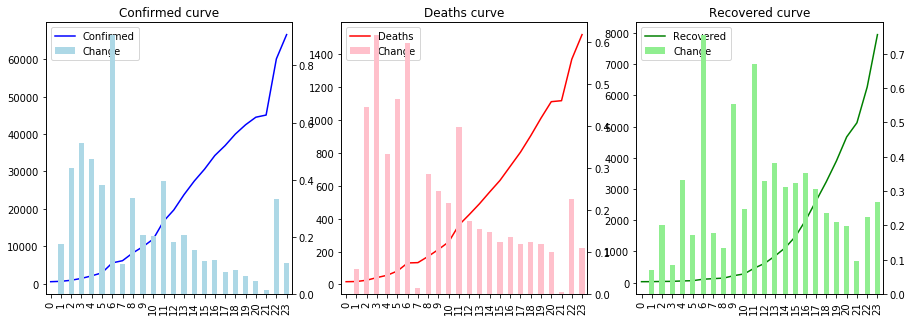

In [40]:
# summary
summary = df.groupby(['Date', 'Country', 'Province'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index()
summary = summary.groupby('Date')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
# summary = summary[summary['Date'] != datetime.date(datetime.now())] # ignore today
summary['Confirmed Change'] = summary['Confirmed'].pct_change()
summary['Recovered Change'] = summary['Recovered'].pct_change()
summary['Deaths Change'] = summary['Deaths'].pct_change()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

summary['Confirmed'].plot(ax=axes[0], color='blue', label='Confirmed', title='Confirmed curve', legend=True)
summary['Confirmed Change'].plot.bar(ax=axes[0], secondary_y=True, color='lightblue', label='Change', legend=True, mark_right=False)

summary['Deaths'].plot(ax=axes[1], color='red', label='Deaths', title='Deaths curve', legend=True)
summary['Deaths Change'].plot.bar(ax=axes[1], secondary_y=True, color='pink', label='Change', legend=True, mark_right=False)

summary['Recovered'].plot(ax=axes[2], color='green', label='Recovered', title='Recovered curve', legend=True)
summary['Recovered Change'].plot.bar(ax=axes[2], secondary_y=True, color='lightgreen', label='Change', legend=True, mark_right=False)

c:\users\haggais\appdata\local\continuum\miniconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


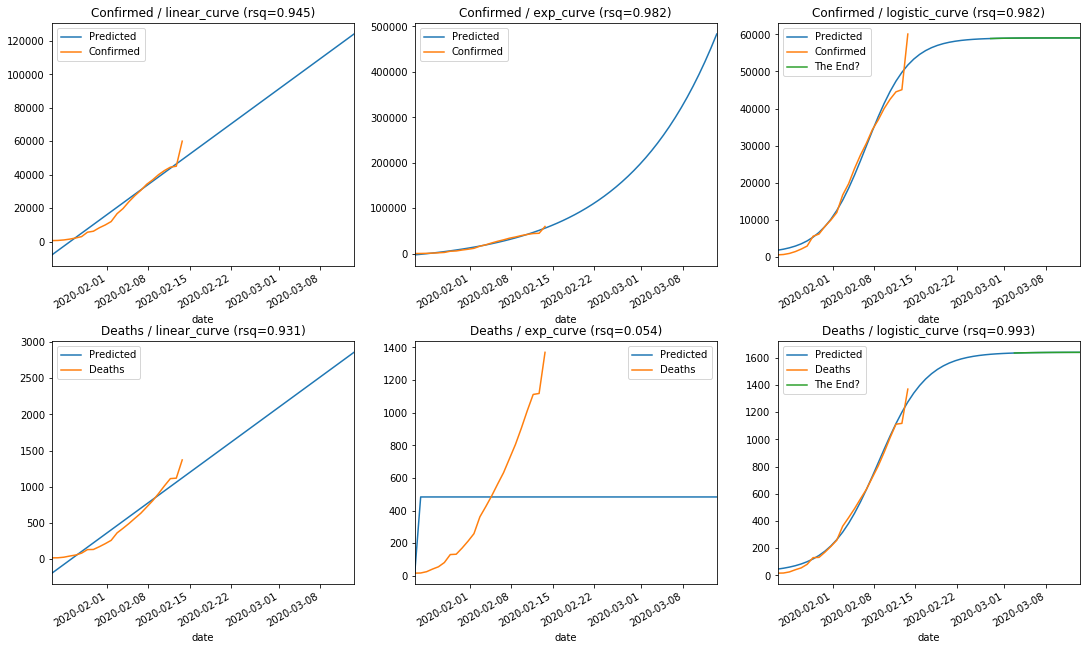

In [28]:
# basic fitting 

def exp_curve(x, a, b, c):
    return a * numpy.exp(-c * x) + b

def linear_curve(x, a, b):
    return a * x + b

def logistic_curve(x, a, b, c):
    return a/(expit(-c * x) + b)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
fig.tight_layout(h_pad=7, w_pad=3)

x = summary.index
t = range(0, max(summary.index) + 30) # predict 3 weeks ahead

for i, curve_func in enumerate([linear_curve, exp_curve, logistic_curve]):
    for j, y_col in enumerate(['Confirmed', 'Deaths']):
        y = summary[y_col]
        popt, pcov = curve_fit(curve_func, x, y)
        pred = curve_func(t, *popt)
        y_pred = curve_func(x, *popt)
        
        res = pd.DataFrame()
        res['date'] = pd.Series(t).apply(lambda x: first_update + timedelta(days=x))
        
        res['Predicted'] = pred        
        res[y_col] = y
        if curve_func == logistic_curve:
            res['The End?'] = res['Predicted'].mul(res['Predicted'].pct_change() < 0.001).apply(lambda x: None if x == 0 else x)
        
        rsq = str(round(r2_score(y, y_pred), 3))
        title = '%s / %s (rsq=%s)' % (y_col, curve_func.__name__, rsq)
        res.plot(x='date', ax=axes[j, i], title=title)

        


In [34]:
# using NN on the summary data frame to emulate a logistic curve

model = keras.Sequential()
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(64, activation='exponential'))
model.add(layers.Dense(1))
model.compile(loss='mse', metrics=['mse', 'mae', 'accuracy'])

x = numpy.array(x)
y = summary['Confirmed'].values
hist = model.fit(x, y, epochs=1000, verbose=0)


t = numpy.array(t)
pred = model.predict(t).flatten()
y_pred = model.predict(x).flatten()

res = pd.DataFrame()
res['Predicted'] = pd.Series(pred)
res['Confirmed'] = pd.Series(y)
res['date'] = pd.Series(t).apply(lambda x: first_update + timedelta(days=x))

    
rsq = str(round(r2_score(y, y_pred), 3))
title = 'Confirmed / NN (rsq=%s)' % (rsq)

res.plot(x='date', title=title)


r2 score 0.9894463358856959


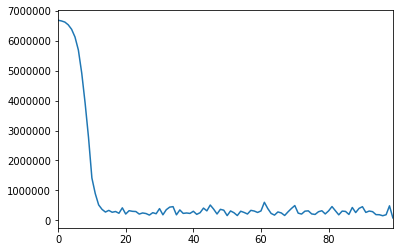

In [33]:
# fitting using NN on the entire dataset 

countries_and_provinces = pd.get_dummies(df[['Country', 'Province']])
lags = df['Lag']

left_input = layers.Input(shape=(1, ))
left_branch = layers.Dense(32)(left_input)
left_branch = layers.BatchNormalization()(left_branch)

right_len = len(countries_and_provinces.columns)
right_input = layers.Input(shape=(right_len, ))
right_branch = layers.Embedding(32, 32, input_length=right_len)(right_input)
right_branch = layers.Flatten()(right_branch)
right_branch = layers.Dense(32)(right_branch)
right_branch = layers.BatchNormalization()(right_branch)

merged = layers.concatenate([left_branch, right_branch])
merged = layers.Dense(32, activation='sigmoid')(merged)
merged = layers.Dense(32, activation='exponential')(merged)
out = layers.Dense(1)(merged)

model = keras.Model(inputs=[left_input, right_input], outputs=out)
model.compile(loss='mse', metrics=['mse', 'mae', 'accuracy'])

x = [lags.values, countries_and_provinces.values]
y = df['Confirmed'].values

hist = model.fit(x, y, epochs=100, verbose=0)
hist = pd.DataFrame(hist.history)
hist['mse'].plot()


y_pred = model.predict(x)
print ('r2 score', r2_score(y, y_pred))


['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Taiwan' 'Tianjin' 'Tibet' 'Washington' 'Xinjiang' 'Yunnan' 'Zhejiang' 0
 'Chicago' 'Illinois' 'California' 'Arizona' 'Ontario' 'New South Wales'
 'Victoria' 'British Columbia' 'Bavaria' 'Queensland' 'Chicago, IL'
 'South Australia' 'Boston, MA' 'Los Angeles, CA' 'Orange, CA'
 'Santa Clara, CA' 'Seattle, WA' 'Tempe, AZ' 'San Benito, CA'
 'Toronto, ON' 'London, ON' 'Madison, WI' 'Cruise Ship'
 'Diamond Princess cruise ship' 'San Diego County, CA' 'San Antonio, TX']


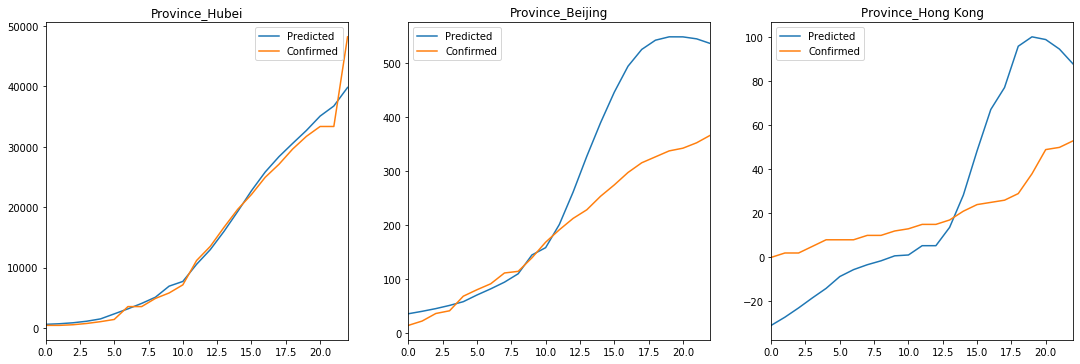

In [35]:
print (df['Province'].unique())

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
fig.tight_layout(h_pad=7, w_pad=3)

for i, province in enumerate(['Province_Hubei', 'Province_Beijing', 'Province_Hong Kong']):
    province_df = countries_and_provinces[countries_and_provinces[province] == 1]
    Lag = province_df.join(df)['Lag']
    y = province_df.join(df)['Confirmed']
    pred = model.predict([Lag.values, province_df.values])
    p = pd.DataFrame()
    p['Predicted'] = pred.flatten()
    p['Confirmed'] = y.values
    p.plot(ax=axes[i], title=province)
